# Generalization Capabilities

In [548]:
import os
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.patches as mpatches
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
from keras import backend as k
from keras.models import Sequential,Model
from keras.layers.convolutional import Conv3D, Conv2D, UpSampling2D,Conv2DTranspose
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,MaxPooling2D,TimeDistributed,Input,concatenate,Flatten,Reshape,LSTM,Lambda

In [331]:
folder_name = '3300_8.7000'
p = './Results/TowerTraining/Recordings/Standard/generalization/'
path = p+folder_name+'/'
folder_name_norm = '3999_16.100'
path_norm = './Results/TowerTraining/Recordings/Standard/'+folder_name_norm+'/'
figure_path = './Results/TowerTraining/Figures/NNFiguresSameOpt/'

obs = np.load(path+'visobs.npy', mmap_mode='r')
obs_norm = np.load(path_norm+'visobs.npy', mmap_mode='r')
vec = np.load(path+'vecobs.npy')

rew = np.load(path+'rewards.npy')

encA = np.load(path+'encodings.npy')
encA = encA.reshape(encA.shape[0],encA.shape[-1])[:,:256]
encA_norm = np.load(path_norm+'encodings.npy')
encA_norm = encA_norm.reshape(encA_norm.shape[0],encA_norm.shape[-1])[:,:256]

actionL = np.load(path+'actions.npy')
val = np.load(path+'values.npy')

floorStats_train = np.load(p+'floorStats_train.npy')[:100]
floorStats_test = np.load(p+'floorStats_test.npy')[:100]
floorStats_rand = np.load(p+'floorStats_rand.npy')[:100]

rewardStats_train = np.load(p+'rewardStats_train.npy')[:100]
rewardStats_test = np.load(p+'rewardStats_test.npy')[:100]
rewardStats_rand = np.load(p+'rewardStats_rand.npy')[:100]

hand_l = pd.read_csv(path+'HandLabels.csv')
label_test = np.zeros(encA.shape[0])
label_test = np.array(hand_l['Label'])

hand_l_norm = pd.read_csv(path_norm+'HandLabels.csv')
label_test_norm = np.zeros(encA_norm.shape[0])
label_test_norm = np.array(hand_l_norm['Label'])

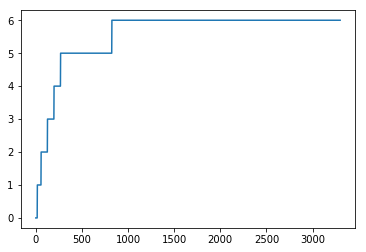

In [521]:
plt.plot(vec[0][:,7])
#plt.xlim([0,1000])
plt.show()

In [520]:
maxReached = np.where(vec[0][:,7]==np.max(vec[0][:,7]))[0][0]

## Agent

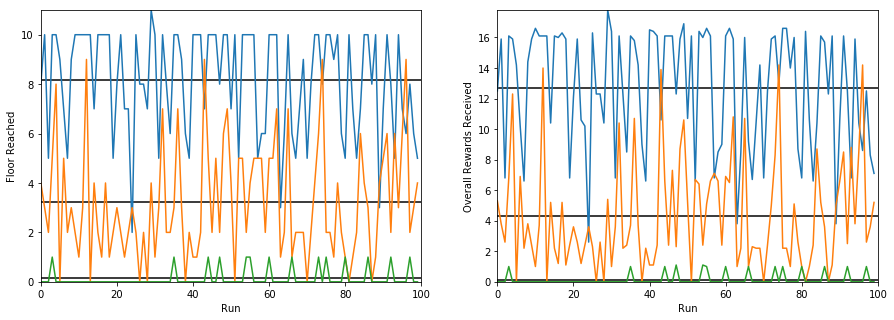

In [332]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(floorStats_train)
plt.plot(floorStats_test)
plt.plot(floorStats_rand)
plt.hlines(np.mean(floorStats_train),0,100)
plt.hlines(np.mean(floorStats_test),0,100)
plt.hlines(np.mean(floorStats_rand),0,100)
plt.xlim([0,100])
plt.ylim([0,11])
plt.xlabel('Run')
plt.ylabel('Floor Reached')
plt.subplot(1,2,2)
plt.plot(rewardStats_train)
plt.plot(rewardStats_test)
plt.plot(rewardStats_rand)
plt.hlines(np.mean(rewardStats_train),0,100)
plt.hlines(np.mean(rewardStats_test),0,100)
plt.hlines(np.mean(rewardStats_rand),0,100)
plt.xlim([0,100])
plt.ylim([0,np.max(rewardStats_train)])
plt.xlabel('Run')
plt.ylabel('Overall Rewards Received')
plt.show()

In [560]:
import glob
from PIL import Image
imlist = glob.glob(p+'examples/*.png')
expIms = np.array([np.array(Image.open(fname)) for fname in imlist])

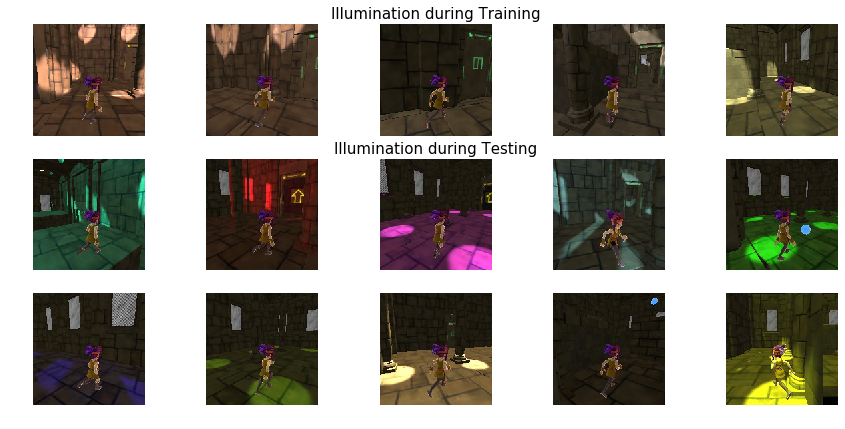

In [573]:
plt.figure(figsize=(15,7))
imNums = [5,35,90,740,1100]
for i in range(15):
    plt.subplot(3,5,i+1)
    if i<5:
        plt.imshow(obs_norm[imNums[i]])
    if i>=5 and i<14:
        #plt.imshow(obs[imNums[i-5]])
        plt.imshow(expIms[i-10])
    if i==14:
        plt.imshow(obs[imNums[-1]])
    if i==2:
        plt.title('Illumination during Training',fontsize=15)
    if i==7:
        plt.title('Illumination during Testing',fontsize=15)
    plt.axis('off')
#plt.show()
plt.savefig(figure_path+'IlluminationExamples.eps', bbox_inches='tight', dpi=300)

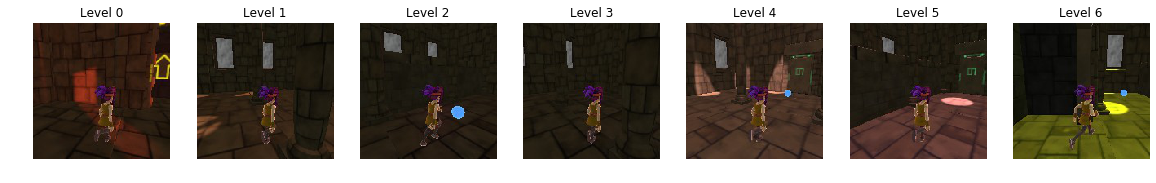

In [534]:
plt.figure(figsize=(20,5))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(obs[np.where(vec[0][:,7]==i)[0][12]])
    plt.axis('off')
    plt.title('Level '+str(i))

In [239]:
def addLabel(currL,ToAdd):
    if ToAdd<=1:
        return currL
    elif ToAdd==2:
        currL[0] = 4
    elif ToAdd==3:
        currL[0] = 2
    elif ToAdd==4:
        currL[0] = 3
    elif ToAdd==5:
        currL[0] = 4
    elif ToAdd==6:
        currL[0]=1
    elif ToAdd==7:
        currL[1]=1
    elif ToAdd==8:
        currL[2]=1
    elif ToAdd==9:
        currL[3]=1
    else:
        print(ToAdd)
    return currL

def formatLabels(labels1,labels2):
    formatted = []
    for i,l in enumerate(labels1):
        newLabel=[0,0,0,0]
        if l == 0:
            print(i)
        newLabel = addLabel(newLabel,l)
        #print(str(i)+': '+str(newLabel)+ '  '+str(l))
        newLabel = addLabel(newLabel,labels2[i])
        #print(str(i)+': '+str(newLabel)+ '  '+str(labels2[i]))
        formatted.append(newLabel)
    return np.array(formatted)

fLabels = formatLabels(np.array(hand_l['Label']),np.array(hand_l['Secondary label']))
fLabels_norm = formatLabels(np.array(hand_l_norm['Label']),np.array(hand_l_norm['Secondary label']))

In [215]:
def where_array_equal(a,b):
    equal = np.zeros(a.shape[0])
    for i,arr in enumerate(a):
        if np.array_equal(arr,b):
            equal[i] = 1
    return equal
w = where_array_equal(actionL[:,0],np.unique(actionL[:,0],axis=0)[3])

combs = np.unique(actionL[:,0],axis=0)
a_vec = np.zeros((combs.shape[0],actionL.shape[0]))
for i,c in enumerate(combs):
    a_vec[i] = where_array_equal(actionL[:,0],c)
#print(a_vec.shape)    

all_a_comb = np.zeros(actionL.shape[0])
for i in range(actionL.shape[0]):
    if a_vec[0][i] == 1:
        all_a_comb[i] = 0#[1, 0, 0, 1] Forward, Turn right
    elif a_vec[3][i] == 1:
        all_a_comb[i] = 1#[1, 1, 0, 1] Forward, Camera Left, Turn Right
    elif a_vec[4][i] == 1:
        all_a_comb[i] = 2#[1, 1, 0, 2] Forward, Camera Left, Turn Left
    elif a_vec[6][i] == 1:
        all_a_comb[i] = 3#[1, 2, 0, 1] Forward, Camera Right, Turn Right
    elif a_vec[13][i] == 1:
        all_a_comb[i] = 4#[2, 2, 0, 1] Backward, Camera Right, Turn Right
    else:
        all_a_comb[i] = 5#Anything else
actions = ['Forward, Turn Right','Forward, Camera Left, Turn Right','Forward, Camera Left, Turn Left',
           'Forward, Camera Right, Turn Right','Backward, Camera Right, Turn Right','Everything Else']
act_lab = ['Forward, Turn Right','Forward, Camera Left, Turn Right','Forward, Camera Left, Turn Left',
           'Forward, Camera Right, Turn Right','Backward, Camera Right, Turn Right','Everything Else']

In [20]:
def getACombLabel(combination,lineBreak=False):
    label = ""
    actionNames = {0:['Stand','Forward','Backward'], 1:['Camera Straight','Camera Left','Camera Right'],
                   2:['Stand','Jump'],3:['Stand','Move Right','Move Left']}
    for b in range(combination.shape[0]):
        if combination[b]>0:
            if b == 0 or len(label) == 0:
                label = label + actionNames[b][combination[b]]
            else:
                if lineBreak:
                    label = label + '\n' + actionNames[b][combination[b]]
                else:
                    label = label + ', ' + actionNames[b][combination[b]]
    return label
def getAllACombs(a_vec,sort,numCombs=5):
    all_a_comb = np.ones(a_vec.shape[-1])
    all_a_comb = all_a_comb*numCombs
    for i in range(a_vec.shape[-1]):
        for comb in range(numCombs):
            if a_vec[sort[comb]][i] == 1:
                all_a_comb[i] = comb
    return all_a_comb
def actionProcessing(actions,numCombs=5):
    combs = np.unique(actions[:,0],axis=0)
    a_vec = np.zeros((combs.shape[0],actions.shape[0]))
    for i,c in enumerate(combs):
        a_vec[i] = where_array_equal(actions[:,0],c)
    count = np.sum(a_vec,axis=1)
    sort = np.argsort(count)[::-1]
    all_a_comb = getAllACombs(a_vec,sort,numCombs)
    labels = []
    for a in combs[sort[:numCombs]]:
        labels.append(getACombLabel(a))
    labels.append('Everything Else')
    return all_a_comb,labels

In [23]:
all_a_comb , act_lab = actionProcessing(actionL)

In [535]:
tsneA_max = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encA[:maxReached])
tsneA = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encA)

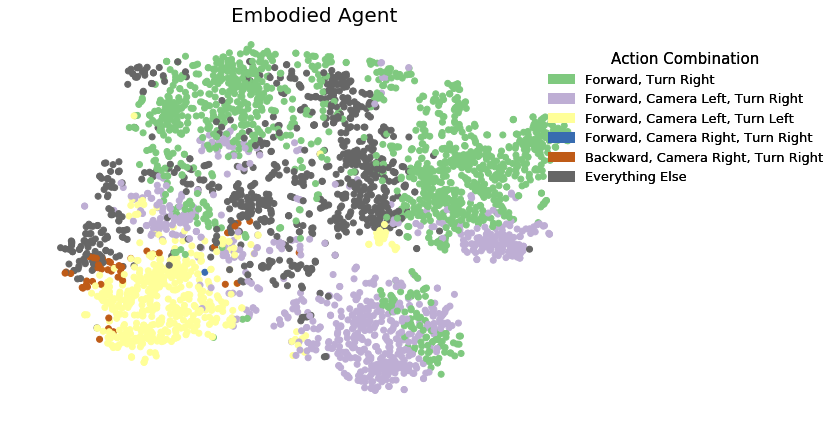

In [536]:
fig = plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Embodied Agent', fontsize=20)
#im1 = plt.scatter(tsneA[:,0],tsneA[:,1],c=all_a_comb[:],cmap='Accent',edgecolors=edgeCs[:],linewidths =edgeWs[:])
im1 = plt.scatter(tsneA[:,0],tsneA[:,1],c=all_a_comb,cmap='Accent')

values = np.linspace(0,5,6)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=act_lab[i] ) for i in range(len(values)) ]
l1 = plt.legend(handles=patches, bbox_to_anchor=(0.91, 0.95), loc=2, borderaxespad=0. , title='Action Combination',title_fontsize=15,fontsize=13,frameon=False)

#line1 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="red")
#line2 = plt.Line2D(range(1), range(1), color="white", marker='o',markersize=7,markerfacecolor="white",markeredgecolor="white")
#l2 = plt.legend((line1,line2),('Level Door',''), bbox_to_anchor=(1, 0.55),numpoints=1, loc=2,fontsize=13,title="Observation Content",title_fontsize=15,frameon=False, borderaxespad=0.)

fig.add_artist(l1)
#fig.add_artist(l2)

plt.axis('off')
plt.show()
#plt.savefig(figure_path+'tsne_actions_A_generalize.eps', bbox_inches='tight',dpi=300)

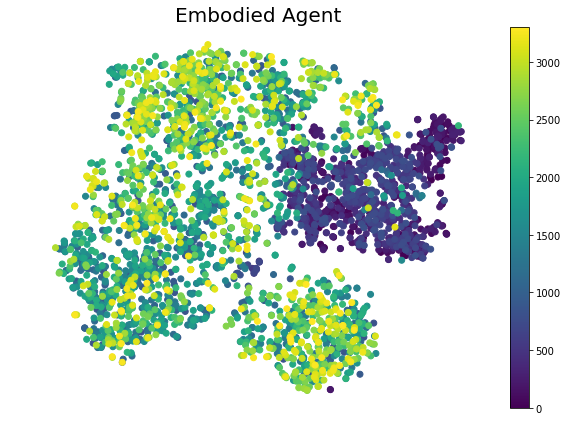

In [537]:
fig = plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Embodied Agent', fontsize=20)
#im1 = plt.scatter(tsneA[:,0],tsneA[:,1],c=all_a_comb[:],cmap='Accent',edgecolors=edgeCs[:],linewidths =edgeWs[:])
im1 = plt.scatter(tsneA[:,0],tsneA[:,1],c=np.linspace(0,tsneA.shape[0]-1,tsneA.shape[0]))
plt.colorbar()

plt.axis('off')
plt.show()
#plt.savefig(figure_path+'tsne_actions_A_generalize.eps', bbox_inches='tight',dpi=300)

In [522]:
both = np.vstack([encA_norm,encA])
tsneBoth = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(both)

In [523]:
both_max = np.vstack([encA_norm,encA[:maxReached]])
tsneBoth_max = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(both_max)

In [524]:
ALabels = np.vstack([np.zeros((encA_norm.shape[0],1)),np.ones((encA.shape[0],1))])
ALabels_max = np.vstack([np.zeros((encA_norm.shape[0],1)),np.ones((maxReached,1))])#encA.shape[0]

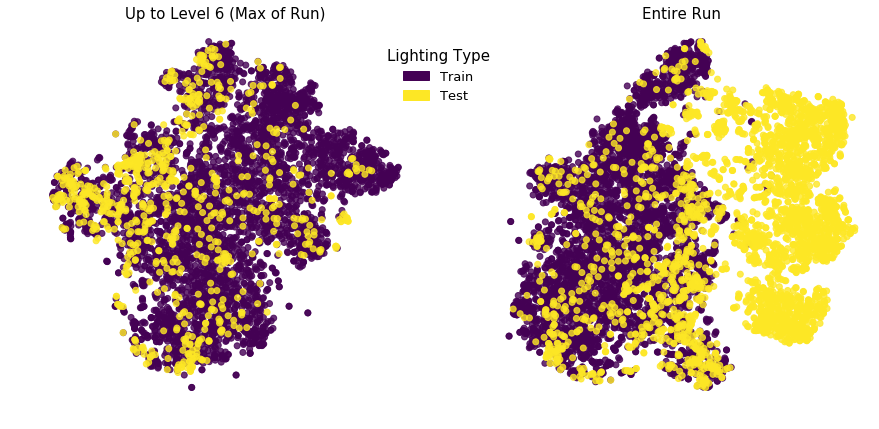

In [538]:
fig = plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title('Up to Level '+str(int(np.max(vec[0][:,7])))+' (Max of Run)', fontsize=15)
im1 = plt.scatter(tsneBoth_max[:,0],tsneBoth_max[:,1],c=ALabels_max.flatten(),alpha= 0.8)
plt.axis('off')
labs = ['Train','Test']
values = [0,1]
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labs[i] ) for i in range(len(values)) ]
l1 = plt.legend(handles=patches, bbox_to_anchor=(0.91, 0.95), loc=2, borderaxespad=0. , title='Lighting Type',title_fontsize=15,fontsize=13,frameon=False)


plt.subplot(1,2,2)

plt.title('Entire Run', fontsize=15)
im2 = plt.scatter(tsneBoth[:,0],tsneBoth[:,1],c=ALabels.flatten(),alpha= 0.8)


plt.axis('off')
#plt.show()
plt.savefig(figure_path+'tsne_enc_A_generalize.eps', bbox_inches='tight',dpi=300)

## Classifier

In [438]:
tf.reset_default_graph()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

o_size_h = 168
o_size_w = 168
vec_obs_size = 8
num_layers = 2
h_size = 256
h_size_vec = 256
            
visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")
labels = tf.placeholder(shape=[None,4], dtype=tf.int64,name="labels")

def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        hidden_vec = observation_input
        for i in range(num_layers):
            hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
    return hidden_vec

def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
          
        conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
           
        hidden_vis = c_layers.flatten(conv2)

    with tf.variable_scope(scope + '/' + 'flat_encoding'):
        hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
    return hidden_flat

def create_discrete_action_masking_layer(all_logits, action_size):
        """
        Creates a masking layer for the discrete actions
        :param all_logits: The concatenated unnormalized action probabilities for all branches
        :param action_size: A list containing the number of possible actions for each branch
        :return: The action output dimension [batch_size, num_branches] and the concatenated normalized logits
        """
        action_idx = [0] + list(np.cumsum(action_size))
        branches_logits = [all_logits[:, action_idx[i]:action_idx[i + 1]] for i in range(len(action_size))]#split in action branches (size=action_size)
        raw_probs = [tf.nn.softmax(branches_logits[k]) + 1.0e-10 for k in range(len(action_size))]
        normalized_probs = [
            tf.divide(raw_probs[k], tf.reduce_sum(raw_probs[k], axis=1, keepdims=True))
            for k in range(len(action_size))]
        #normalized_probs = raw_probs
        output = tf.concat([tf.multinomial(tf.log(normalized_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        #output = tf.concat([tf.multinomial(tf.nn.log_softmax(raw_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        
        log_probs = [tf.log(normalized_probs[k] + 1.0e-10) for k in range(len(action_size))]#xx
        log_probs_flat = tf.concat(log_probs, axis=1)
        return output, log_probs_flat, log_probs

visual_encoders = []

encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
visual_encoders.append(encoded_visual)
hidden_visual = tf.concat(visual_encoders, axis=1)


class_size = [5,2,2,2]
policy_branches = []
for size in class_size:
    policy_branches.append(tf.layers.dense(hidden_visual, size, activation=None, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))
    #policy_branches.append(tf.layers.dense(hidden_visual, size, activation=tf.nn.relu, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))

all_log_probs = tf.concat([branch for branch in policy_branches], axis=1, name="action_probs")

output, normalized_logits_flat, norm_logits = create_discrete_action_masking_layer(all_log_probs, class_size)

output = tf.identity(output)
normalized_logits = tf.identity(normalized_logits_flat, name='action')#has nan in places where prob is negative bc it it log(probs)

saver = tf.train.Saver()

In [439]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver.restore(sess, "./Results/TowerTraining/Classifier/Model_lr0001_scaled/model.ckpt")

INFO:tensorflow:Restoring parameters from ./Results/TowerTraining/Classifier/Model_lr0001_scaled/model.ckpt


In [475]:
encC,outC = sess.run([encoded_visual,output], feed_dict = {visual_in: obs})

In [486]:
encC_train,outC_train = sess.run([encoded_visual,output], feed_dict = {visual_in: obs_norm})

c:\users\vkakerbeck\miniconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


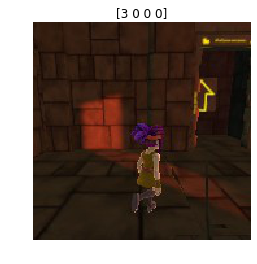

In [476]:
i=11
plt.imshow(obs[i])
plt.axis('off')
plt.title(outC[i])
plt.show()

In [443]:
def getFP_FN(o,l):
    w = np.where(l!=o)
    FN = np.sum((o[w]==0)&(l[w]==1))/len(w[0])*100
    FP = np.sum((o[w]>0)&(l[w]==0))/len(w[0])*100
    return np.round(FP,3),np.round(FN,3)

def getAccPR(o,l):
    w = np.where(l!=o)
    trueP = np.sum((o==l)&(o==1))
    trueN = np.sum((o==l)&(o==0))
    falseP = np.sum((o[w]>0)&(l[w]==0))
    falseN = np.sum((o[w]==0)&(l[w]==1))
    Acc = (trueP+trueN)/len(o)*100
    Precision = np.nan_to_num(trueP/(trueP+falseP)*100)
    Recall = np.nan_to_num(trueP/(trueP+falseN)*100)
    F1Score = np.nan_to_num(2 * ((Precision * Recall) / (Precision + Recall)))
    return np.round(Acc,3),np.round(Precision,3),np.round(Recall,3), F1Score, [trueP,trueN,falseP,falseN]

def printPerformance(out,fLabels,getStats=False):
    print('Accuracy: '+str(np.mean(out==fLabels)*100)+'%')
    print('Everything correct in '+str(np.sum(np.mean(out==fLabels,axis=1)==1.0)/len(fLabels)*100)+'%')
    print('Correct Door in '+str(np.round(np.mean(np.array(fLabels)[:,0]==out[:,0])*100,3))+'%')

    AccND,PND,RND,FND,NDA = getAccPR((out[:,0]==0).astype(int),(fLabels[:,0]==0).astype(int))
    print('     No Door - Acc: '+str(AccND)+'% Precision: '+str(PND)+'% Recall: '+str(RND)+
          '% F1 Score: '+ str(FND)+'%  |  TP,TN,FP,FN: '+str(NDA))

    AccLD,PLD,RLD,FLD,LDA = getAccPR((out[:,0]==1).astype(int),(fLabels[:,0]==1).astype(int))
    print('     Level Door - Acc: '+str(AccLD)+'% Precision: '+str(PLD)+'% Recall: '+str(RLD)+
          '% F1 Score: '+ str(FLD)+'%  |  TP,TN,FP,FN: '+str(LDA))

    AccGD,PGD,RGD,FGD,GDA = getAccPR((out[:,0]==2).astype(int),(fLabels[:,0]==2).astype(int))
    print('     Green Door - Acc: '+str(AccGD)+'% Precision: '+str(PGD)+'% Recall: '+str(RGD)+
          '% F1 Score: '+ str(FGD)+'%  |  TP,TN,FP,FN: '+str(GDA))

    AccKD,PKD,RKD,FKD,KDA = getAccPR((out[:,0]==3).astype(int),(fLabels[:,0]==3).astype(int))
    print('     Key Door - Acc: '+str(AccKD)+'% Precision: '+str(PKD)+'% Recall: '+str(RKD)+
          '% F1 Score: '+ str(FKD)+'%  |  TP,TN,FP,FN: '+str(KDA))

    AccOD,POD,ROD,FOD,ODA = getAccPR((out[:,0]==4).astype(int),(fLabels[:,0]==4).astype(int))
    print('     Other Door - Acc: '+str(AccOD)+'% Precision: '+str(POD)+'% Recall: '+str(ROD)+
          '% F1 Score: '+ str(FOD)+'%  |  TP,TN,FP,FN: '+str(ODA))

    AccK,PK,RK,FK,KA = getAccPR(out[:,1],np.array(fLabels)[:,1])
    print('Correct Key in '+str(AccK)+'% - Precision: '+
          str(PK)+'% Recall: '+ str(RK) +
          '% F1 Score: '+ str(FK)+str(RK)+'%  |  TP,TN,FP,FN: '+str(KA))

    AccO,PO,RO,FO,OA = getAccPR(out[:,2],np.array(fLabels)[:,2])
    print('Correct Orb in '+str(AccO)+'% - Precision: '+
          str(PO)+'% Recall: '+ str(RO) +
          '% F1 Score: '+ str(FO)+str(RO)+'%  |  TP,TN,FP,FN: '+str(OA))

    AccP,PP,RP,FP,PA = getAccPR(out[:,3],np.array(fLabels)[:,3])
    print('Correct Puzzle in '+str(AccP)+'% - Precision: '+
          str(PP)+'% Recall: '+ str(RP) +
          '% F1 Score: '+ str(FP)+str(RP)+'%  |  TP,TN,FP,FN: '+str(PA))
    if getStats:
        AllAcc = np.array([AccND,AccLD,AccGD,AccKD,AccOD,AccK,AccO,AccP])
        AllP = np.array([PND,PLD,PGD,PKD,POD,PK,PO,PP])
        AllR = np.array([RND,RLD,RGD,RKD,ROD,RK,RO,RP])
        AllF1 = np.array([FND,FLD,FGD,FKD,FOD,FK,FO,FP])
        return AllAcc, AllP, AllR, AllF1

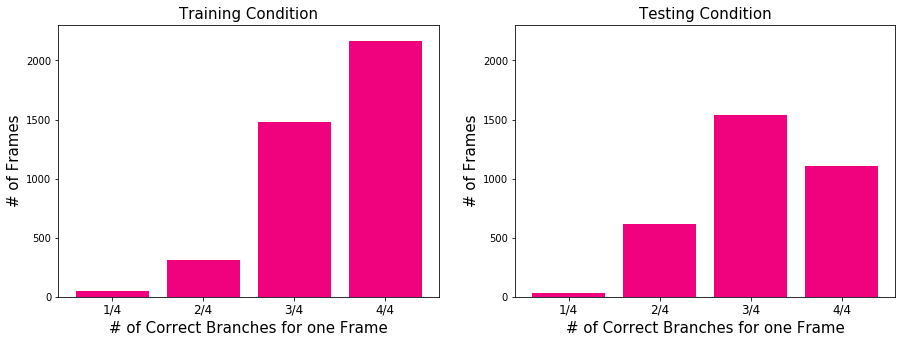

In [487]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(np.linspace(0,3,4),np.histogram(np.mean(outC_train==fLabels_norm,axis=1),bins=4)[0],color=sns.color_palette("Accent", n_colors=8)[5])
plt.xticks(np.linspace(0,3,4),['1/4','2/4','3/4','4/4'],fontsize=12)
plt.xlabel('# of Correct Branches for one Frame',fontsize=15)
plt.ylabel('# of Frames',fontsize=15)
plt.ylim([0,2300])
plt.title('Training Condition',fontsize=15)
plt.subplot(1,2,2)
plt.bar(np.linspace(0,3,4),np.histogram(np.mean(outC==fLabels,axis=1),bins=4)[0],color=sns.color_palette("Accent", n_colors=8)[5])
plt.xticks(np.linspace(0,3,4),['1/4','2/4','3/4','4/4'],fontsize=12)
plt.xlabel('# of Correct Branches for one Frame',fontsize=15)
plt.ylabel('# of Frames',fontsize=15)
plt.ylim([0,2300])
plt.title('Testing Condition',fontsize=15)
plt.show()
#plt.savefig(figure_path+'Classifier_PerformanceDist_generalization.png', bbox_inches='tight',dpi=300)

In [489]:
Acc_C_train, P_C_train, R_C_train, F1_C_train = printPerformance(outC_train,fLabels_norm,getStats=True)

Accuracy: 85.94375%
Everything correct in 54.05%
Correct Door in 65.075%
     No Door - Acc: 77.075% Precision: 84.991% Recall: 68.212% F1 Score: 75.6828427472819%  |  TP,TN,FP,FN: [1427, 1656, 252, 665]
     Level Door - Acc: 98.675% Precision: 86.517% Recall: 84.153% F1 Score: 85.31855955678671%  |  TP,TN,FP,FN: [154, 3793, 24, 29]
     Green Door - Acc: 75.75% Precision: 46.049% Recall: 57.418% F1 Score: 51.108870967741936%  |  TP,TN,FP,FN: [507, 2523, 594, 376]
     Key Door - Acc: 86.475% Precision: 38.9% Recall: 46.262% F1 Score: 42.26254002134472%  |  TP,TN,FP,FN: [198, 3261, 311, 230]
     Other Door - Acc: 92.175% Precision: 59.475% Recall: 76.57% F1 Score: 66.94825765575501%  |  TP,TN,FP,FN: [317, 3370, 216, 97]
Correct Key in 97.55% - Precision: 2.941% Recall: 5.882% F1 Score: 3.92156862745098025.882%  |  TP,TN,FP,FN: [2, 3900, 66, 32]
Correct Orb in 93.125% - Precision: 50.272% Recall: 66.787% F1 Score: 57.3643410852713266.787%  |  TP,TN,FP,FN: [185, 3540, 183, 92]
Correct 

In [491]:
Acc_C_test, P_C_test, R_C_test, F1_C_test = printPerformance(outC,fLabels,getStats=True)

Accuracy: 78.18939393939394%
Everything correct in 33.60606060606061%
Correct Door in 49.091%
     No Door - Acc: 63.515% Precision: 64.583% Recall: 61.405% F1 Score: 62.95384615384616%  |  TP,TN,FP,FN: [1023, 1073, 561, 643]
     Level Door - Acc: 98.909% Precision: 95.745% Recall: 56.962% F1 Score: 71.42857142857143%  |  TP,TN,FP,FN: [45, 3219, 2, 34]
     Green Door - Acc: 73.939% Precision: 53.05% Recall: 41.417% F1 Score: 46.517412935323385%  |  TP,TN,FP,FN: [374, 2066, 331, 529]
     Key Door - Acc: 89.182% Precision: 56.098% Recall: 12.534% F1 Score: 20.489977728285076%  |  TP,TN,FP,FN: [46, 2897, 36, 321]
     Other Door - Acc: 72.636% Precision: 14.966% Recall: 46.316% F1 Score: 22.62210796915167%  |  TP,TN,FP,FN: [132, 2265, 750, 153]
Correct Key in 95.818% - Precision: 5.556% Recall: 1.887% F1 Score: 2.81690140845070451.887%  |  TP,TN,FP,FN: [2, 3160, 34, 104]
Correct Orb in 73.424% - Precision: 12.528% Recall: 52.113% F1 Score: 20.2001819836214752.113%  |  TP,TN,FP,FN: [111

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [492]:
fLabelsR = np.copy(fLabels_norm)
np.random.shuffle(fLabelsR)

In [493]:
Acc_S, P_S, R_S, F1_S = printPerformance(outC_train,fLabelsR,getStats=True)

Accuracy: 70.3875%
Everything correct in 17.65%
Correct Door in 31.45%
     No Door - Acc: 49.925% Precision: 52.65% Recall: 42.256% F1 Score: 46.88411561919916%  |  TP,TN,FP,FN: [884, 1113, 795, 1208]
     Level Door - Acc: 91.375% Precision: 4.494% Recall: 4.372% F1 Score: 4.432132963988919%  |  TP,TN,FP,FN: [8, 3647, 170, 175]
     Green Door - Acc: 63.0% Precision: 22.888% Recall: 28.539% F1 Score: 25.403225806451612%  |  TP,TN,FP,FN: [252, 2268, 849, 631]
     Key Door - Acc: 79.425% Precision: 11.198% Recall: 13.318% F1 Score: 12.166488794023481%  |  TP,TN,FP,FN: [57, 3120, 452, 371]
     Other Door - Acc: 79.175% Precision: 10.694% Recall: 13.768% F1 Score: 12.038014783526929%  |  TP,TN,FP,FN: [57, 3110, 476, 357]
Correct Key in 97.45% - Precision: 0.0% Recall: 0.0% F1 Score: 0.00.0%  |  TP,TN,FP,FN: [0, 3898, 68, 34]
Correct Orb in 85.075% - Precision: 6.522% Recall: 8.664% F1 Score: 7.4418604651162798.664%  |  TP,TN,FP,FN: [24, 3379, 344, 253]
Correct Puzzle in 67.575% - Preci

c:\users\vkakerbeck\miniconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


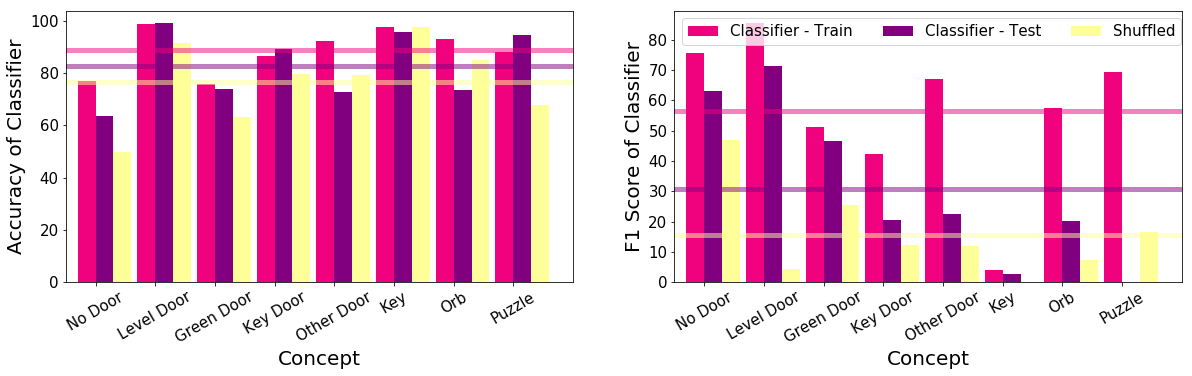

In [494]:
figure_labels = ['No Door', 'Level Door', 'Green Door', 'Key Door', 'Other Door', 'Key', 'Orb', 'Puzzle']

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.bar(np.linspace(-0.15,6.85,8),Acc_C_train,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])
plt.bar(np.linspace(0.15,7.15,8),Acc_C_test,width=0.3,color='purple')
plt.bar(np.linspace(0.45,7.45,8),Acc_S,width=0.3,color=sns.color_palette("Accent", n_colors=8)[3])

plt.xlabel('Concept',fontsize=20)
plt.ylabel('Accuracy of Classifier',fontsize=20)
#plt.legend(['Classifier - Train','Classifier - Test','Shuffled'],fontsize=15,ncol=3,loc=2)

plt.plot([-0.5,8],[np.mean(Acc_C_train), np.mean(Acc_C_train)],color=sns.color_palette("Accent", n_colors=8)[5],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(Acc_C_test), np.mean(Acc_C_test)],color='purple',lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(Acc_S), np.mean(Acc_S)],color=sns.color_palette("Accent", n_colors=8)[3],lw=5,alpha=0.5)

plt.xlim([-0.5,8])
plt.yticks(fontsize=15)
plt.xticks(np.linspace(0,7,8),figure_labels,fontsize=15,rotation=30)

plt.subplot(1,2,2)
plt.bar(np.linspace(-0.15,6.85,8),F1_C_train,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])
plt.bar(np.linspace(0.15,7.15,8),F1_C_test,width=0.3,color='purple')
plt.bar(np.linspace(0.45,7.45,8),F1_S,width=0.3,color=sns.color_palette("Accent", n_colors=8)[3])

plt.xlabel('Concept',fontsize=20)
plt.ylabel('F1 Score of Classifier',fontsize=20)
plt.legend(['Classifier - Train','Classifier - Test','Shuffled'],fontsize=15,ncol=3,loc=2)

plt.plot([-0.5,8],[np.mean(F1_C_train), np.mean(F1_C_train)],color=sns.color_palette("Accent", n_colors=8)[5],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_C_test), np.mean(F1_C_test)],color='purple',lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_S), np.mean(F1_S)],color=sns.color_palette("Accent", n_colors=8)[3],lw=5,alpha=0.5)

plt.xlim([-0.5,8])
plt.yticks(fontsize=15)
plt.xticks(np.linspace(0,7,8),figure_labels,fontsize=15,rotation=30)
#plt.savefig(figure_path+'HighD_Action_Distances.eps', bbox_inches='tight',dpi=300)
plt.show()

In [495]:
np.mean(F1_S)

15.606257814340937

In [481]:
tsneC = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encC)

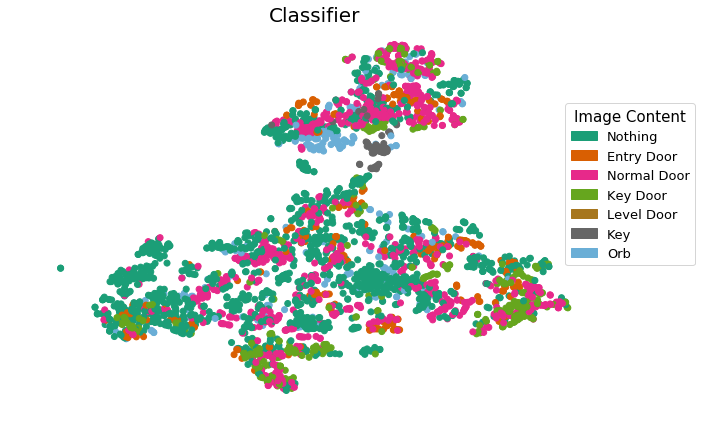

In [483]:
label_test = np.array(hand_l['Label'])
top = plt.cm.get_cmap('Dark2')
bottom = plt.cm.get_cmap('Blues')

newcolors = np.vstack((top(np.linspace(0, 1, 6)),
                       bottom(np.linspace(0.5, 1, 1))))
cmapnew = mpl.colors.ListedColormap(newcolors, name='GreyBlue')

sem_lab = ['Nothing','Entry Door','Normal Door',
           'Key Door','Level Door','Key','Orb']

plt.figure(figsize=(10,7))
#plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
plt.title('Classifier', fontsize=20)
im1 = plt.scatter(tsneC[:,0],tsneC[:,1],c=label_test,cmap=cmapnew)
values = np.linspace(1,7,7)
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=sem_lab[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.95, 0.8), loc=2, borderaxespad=0. , title='Image Content',title_fontsize=15,fontsize=13)

plt.axis('off')
plt.show()
#plt.savefig(figure_path+'tsne_semantic_C_generalization.eps', bbox_inches='tight',dpi=300)

## Autoencoder

In [454]:
from keras import backend as K
K.clear_session()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

inImg = Input(batch_shape=(None,168, 168, 3),name="input_1")
conv1 = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, name="conv_1")(inImg)
#conv1 = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu,weights=[model_vars['main_graph_0_encoder0/conv_1/kernel:0'],model_vars['main_graph_0_encoder0/conv_1/bias:0']], name="conv_1")(inImg)
print(conv1)
conv2 = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="conv_2")(conv1)
#conv2 = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu,weights=[model_vars['main_graph_0_encoder0/conv_2/kernel:0'],model_vars['main_graph_0_encoder0/conv_2/bias:0']], name="conv_2")(conv1)
print(conv2)
flat = Reshape((19*19*32,))(conv2)#Flatten()(conv)
print(flat)
dens = Dense(256,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_1")(flat)
#dens = Dense(256,activation=swish,weights=[model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_0/kernel:0'],model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_0/bias:0']], name="dens_1")(flat)
print(dens)
enc = Dense(256,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_2")(dens)
#enc = Dense(256,activation=swish,weights=[model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/kernel:0'],model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/bias:0']], name="dens_2")(dens)
print(enc)
de_dens = Dense(20*20*32,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_3")(enc)
print(de_dens)
shaped = Reshape((20, 20, 32))(de_dens)
print(shaped)
de_conv = Conv2DTranspose(filters=16, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="deconv_1")(shaped)
print(de_conv)
#de_conv = Conv2DTranspose(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, name="deconv_2")(de_conv)
#print(de_conv)
prediction = Conv2DTranspose(filters=3, kernel_size=[8, 8], strides=[4, 4],padding='same',activation=tf.nn.elu, name="deconv_3")(de_conv)
print(prediction)
model = Model(inputs=inImg, outputs=prediction)

optimizer = tf.train.AdamOptimizer(0.0001)

model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['accuracy','mse'])

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[model.get_layer('dens_2').output,model.get_layer('deconv_3').output])

Tensor("conv_1/Elu:0", shape=(?, 41, 41, 16), dtype=float32)
Tensor("conv_2/Elu:0", shape=(?, 19, 19, 32), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 11552), dtype=float32)
Tensor("dens_1/Mul:0", shape=(?, 256), dtype=float32)
Tensor("dens_2/Mul:0", shape=(?, 256), dtype=float32)
Tensor("dens_3/Mul:0", shape=(?, 12800), dtype=float32)
Tensor("reshape_2/Reshape:0", shape=(?, 20, 20, 32), dtype=float32)
Tensor("deconv_1/Elu:0", shape=(?, ?, ?, 16), dtype=float32)
Tensor("deconv_3/Elu:0", shape=(?, ?, ?, 3), dtype=float32)


In [496]:
encAE_init, outAE_init = intermediate_layer_model.predict(obs)

In [497]:
model.load_weights('./Results/TowerTraining/Recordings/Standard/3999_16.100/autoencoder/aemodelAdam50E.h5')

In [498]:
encAE, outAE = intermediate_layer_model.predict(obs)

In [499]:
encAE_norm, outAE_norm = intermediate_layer_model.predict(obs_norm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


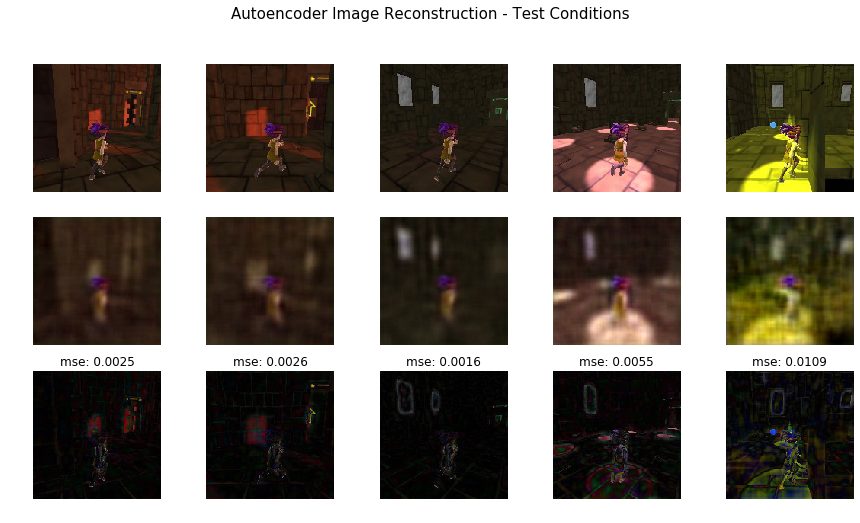

In [502]:
imNums = [5,10,90,740,900]
plt.figure(figsize=(15,8))
plt.suptitle('Autoencoder Image Reconstruction - Test Conditions',fontsize=15)
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(obs[imNums[i]])
    plt.axis('off')
    plt.subplot(3,5,i+6)
    plt.imshow(outAE[imNums[i]])
    plt.axis('off')
    plt.subplot(3,5,i+11)
    plt.imshow(np.abs(obs[imNums[i]] - outAE[imNums[i]]))
    plt.title('mse: '+str(np.round(np.mean(np.square(obs[imNums[i]] - outAE[imNums[i]])),4)))
    plt.axis('off')
plt.show()
#plt.savefig(figure_path+'AEGeneralization_test.eps', bbox_inches='tight', dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


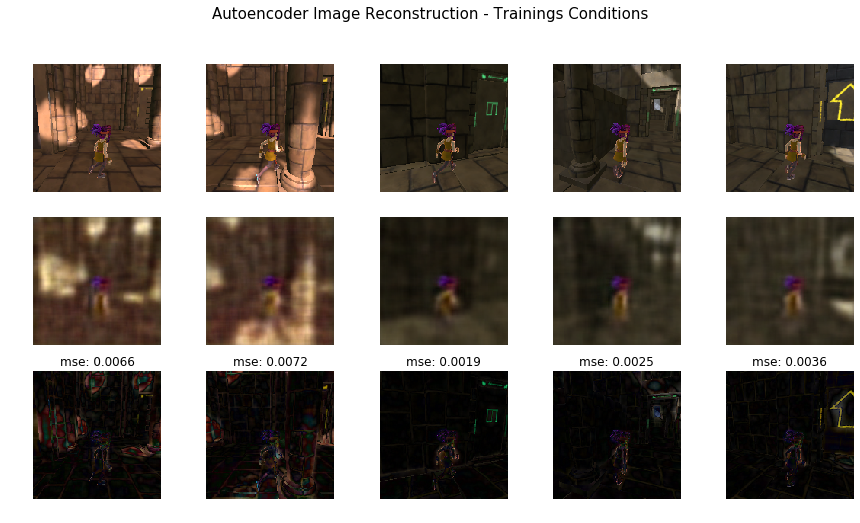

In [503]:
plt.figure(figsize=(15,8))
plt.suptitle('Autoencoder Image Reconstruction - Trainings Conditions',fontsize=15)
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(obs_norm[imNums[i]])
    plt.axis('off')
    plt.subplot(3,5,i+6)
    plt.imshow(outAE_norm[imNums[i]])
    plt.axis('off')
    plt.subplot(3,5,i+11)
    plt.imshow(np.abs(obs_norm[imNums[i]] - outAE_norm[imNums[i]]))
    plt.title('mse: '+str(np.round(np.mean(np.square(obs_norm[imNums[i]] - outAE_norm[imNums[i]])),4)))
    plt.axis('off')
plt.show()
#plt.savefig(figure_path+'AEGeneralization_train.eps', bbox_inches='tight', dpi=300)

In [504]:
outAE_flat = outAE.reshape((outAE.shape[0],168*168*3))
obs_flat = obs.reshape((obs.shape[0],168*168*3))
mse = (np.square(outAE_flat-obs_flat)).mean(axis=1)

In [505]:
outAE_norm_flat = outAE_norm.reshape((outAE_norm.shape[0],168*168*3))
obs_norm_flat = obs_norm.reshape((obs_norm.shape[0],168*168*3))
mse_norm = (np.square(outAE_norm_flat-obs_norm_flat)).mean(axis=1)

In [506]:
outAE_init_flat = outAE_init.reshape((outAE_init.shape[0],168*168*3))
mse_init = (np.square(outAE_init_flat-obs_flat)).mean(axis=1)

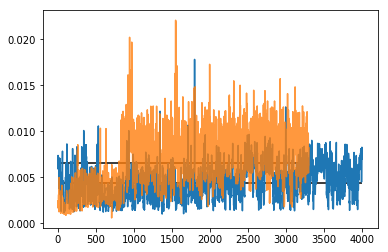

In [507]:
plt.plot(mse_norm)
plt.plot(mse,alpha=0.8)
#plt.plot(mse_init,alpha=0.8)
plt.hlines(np.mean(mse_norm),0,mse_norm.shape[0])
plt.hlines(np.mean(mse),0,mse.shape[0])
#plt.hlines(np.mean(mse_init),0,mse.shape[0])
plt.show()

## Comparison

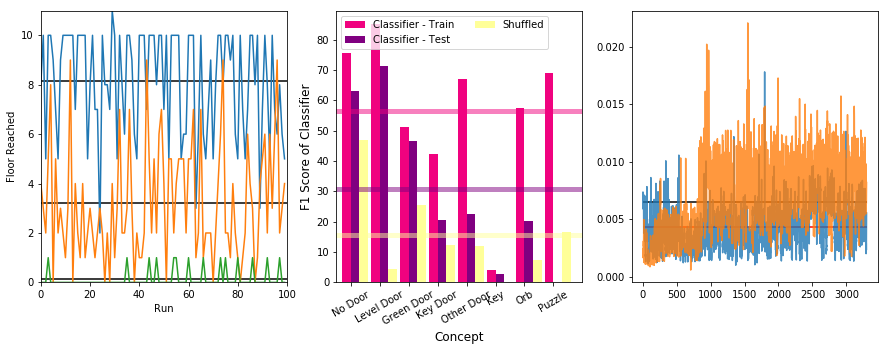

In [547]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(floorStats_train)
plt.plot(floorStats_test)
plt.plot(floorStats_rand)
plt.hlines(np.mean(floorStats_train),0,100)
plt.hlines(np.mean(floorStats_test),0,100)
plt.hlines(np.mean(floorStats_rand),0,100)
plt.xlim([0,100])
plt.ylim([0,11])
plt.xlabel('Run')
plt.ylabel('Floor Reached')

plt.subplot(1,3,2)
plt.bar(np.linspace(-0.15,6.85,8),F1_C_train,width=0.3,color=sns.color_palette("Accent", n_colors=8)[5])
plt.bar(np.linspace(0.15,7.15,8),F1_C_test,width=0.3,color='purple')
plt.bar(np.linspace(0.45,7.45,8),F1_S,width=0.3,color=sns.color_palette("Accent", n_colors=8)[3])

plt.xlabel('Concept',fontsize=12)
plt.ylabel('F1 Score of Classifier',fontsize=12)
plt.legend(['Classifier - Train','Classifier - Test','Shuffled'],fontsize=10,ncol=2,loc=2)

plt.plot([-0.5,8],[np.mean(F1_C_train), np.mean(F1_C_train)],color=sns.color_palette("Accent", n_colors=8)[5],lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_C_test), np.mean(F1_C_test)],color='purple',lw=5,alpha=0.5)
plt.plot([-0.5,8],[np.mean(F1_S), np.mean(F1_S)],color=sns.color_palette("Accent", n_colors=8)[3],lw=5,alpha=0.5)

plt.xlim([-0.5,8])
plt.yticks(fontsize=10)
plt.xticks(np.linspace(0,7,8),figure_labels,fontsize=10,rotation=30)

plt.subplot(1,3,3)
plt.plot(mse_norm[:3300],alpha=0.8)
plt.plot(mse,alpha=0.8)
plt.hlines(np.mean(mse_norm),0,mse.shape[0],color='r')
plt.hlines(np.mean(mse),0,mse.shape[0])
plt.show()

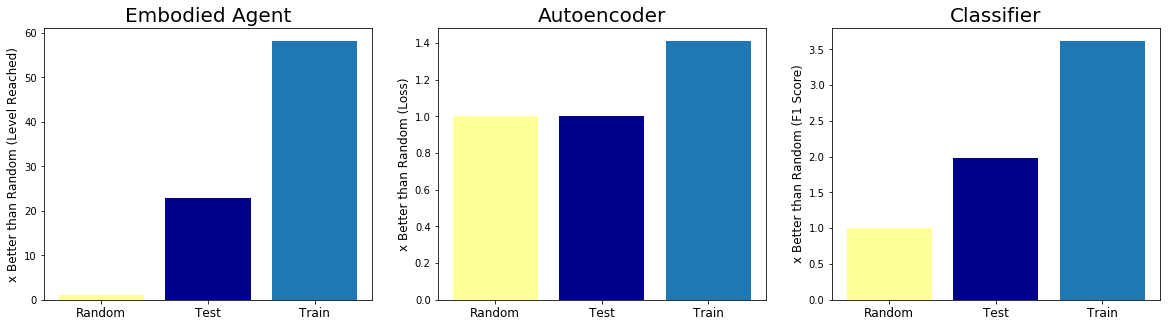

In [511]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.bar(3,np.mean(floorStats_train)/np.mean(floorStats_rand))
plt.bar(2,np.mean(floorStats_test)/np.mean(floorStats_rand),color='darkblue')
plt.bar(1,np.mean(floorStats_rand)/np.mean(floorStats_rand),color=sns.color_palette("Accent", n_colors=8)[3])
plt.ylabel('x Better than Random (Level Reached)',fontsize=12)
plt.xticks([1,2,3],['Random','Test','Train'],fontsize=12)
plt.title('Embodied Agent',fontsize=20)

plt.subplot(1,3,2)
plt.bar(3,np.mean(1/mse_norm[:3300])/np.mean(1/mse_init))
plt.bar(2,np.mean(1/mse)/np.mean(1/mse_init),color='darkblue')
plt.bar(1,np.mean(1/mse_init)/np.mean(1/mse_init),color=sns.color_palette("Accent", n_colors=8)[3])
plt.ylabel('x Better than Random (Loss)',fontsize=12)
plt.xticks([1,2,3],['Random','Test','Train'],fontsize=12)
plt.title('Autoencoder',fontsize=20)

plt.subplot(1,3,3)
plt.bar(3,np.mean(F1_C_train)/np.mean(F1_S))
plt.bar(2,np.mean(F1_C_test)/np.mean(F1_S),color='darkblue')
plt.bar(1,np.mean(F1_S)/np.mean(F1_S),color=sns.color_palette("Accent", n_colors=8)[3])
plt.ylabel('x Better than Random (F1 Score)',fontsize=12)
plt.xticks([1,2,3],['Random','Test','Train'],fontsize=12)
plt.title('Classifier',fontsize=20)

plt.show()
#plt.savefig(figure_path+'GeneralizationComp_BetterRand.png', bbox_inches='tight', dpi=300)

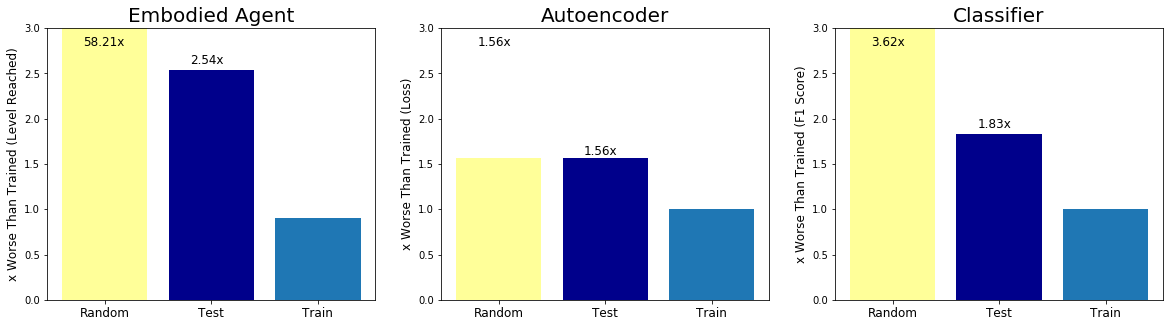

In [512]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.bar(3,1/np.mean(floorStats_train)/np.mean(1/floorStats_train))
plt.bar(2,(1/np.mean(floorStats_test))/(1/np.mean(floorStats_train)),color='darkblue')
plt.bar(1,(1/np.mean(floorStats_rand))/(1/np.mean(floorStats_train)),color=sns.color_palette("Accent", n_colors=8)[3])
plt.text(0.8,2.8,str(np.round((1/np.mean(floorStats_rand))/(1/np.mean(floorStats_train)),2))+'x',fontsize=12)
plt.text(1.8,2.6,str(np.round((1/np.mean(floorStats_test))/(1/np.mean(floorStats_train)),2))+'x',fontsize=12)
plt.ylabel('x Worse Than Trained (Level Reached)',fontsize=12)
plt.xticks([1,2,3],['Random','Test','Train'],fontsize=12)
plt.ylim([0,3])
plt.title('Embodied Agent',fontsize=20)

plt.subplot(1,3,2)
plt.bar(3,np.mean(mse_norm[:3300])/np.mean(mse_norm[:3300]))
plt.bar(2,np.mean(mse)/np.mean(mse_norm[:3300]),color='darkblue')
plt.bar(1,np.mean(mse_init)/np.mean(mse_norm[:3300]),color=sns.color_palette("Accent", n_colors=8)[3])
plt.text(0.8,2.8,str(np.round(np.mean(mse_init)/np.mean(mse_norm[:3300]),2))+'x',fontsize=12)
plt.text(1.8,1.6,str(np.round(np.mean(mse)/np.mean(mse_norm[:3300]),2))+'x',fontsize=12)
plt.ylabel('x Worse Than Trained (Loss)',fontsize=12)
plt.xticks([1,2,3],['Random','Test','Train'],fontsize=12)
plt.ylim([0,3])
plt.title('Autoencoder',fontsize=20)

plt.subplot(1,3,3)
plt.bar(3,(1/np.mean(F1_C_train))/(1/np.mean(F1_C_train)))
plt.bar(2,(1/np.mean(F1_C_test))/(1/np.mean(F1_C_train)),color='darkblue')
plt.bar(1,(1/np.mean(F1_S))/(1/np.mean(F1_C_train)),color=sns.color_palette("Accent", n_colors=8)[3])
plt.text(0.8,2.8,str(np.round((1/np.mean(F1_S))/(1/np.mean(F1_C_train)),2))+'x',fontsize=12)
plt.text(1.8,1.9,str(np.round((1/np.mean(F1_C_test))/(1/np.mean(F1_C_train)),2))+'x',fontsize=12)
plt.ylabel('x Worse Than Trained (F1 Score)',fontsize=12)
plt.xticks([1,2,3],['Random','Test','Train'],fontsize=12)
plt.ylim([0,3])
plt.title('Classifier',fontsize=20)

plt.show()
#plt.savefig(figure_path+'GeneralizationComp_WorseTrained.eps', bbox_inches='tight', dpi=300)